In [68]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load data + embeddings
df = pd.read_csv("Occupations_with_summaries_and_exposure.csv")
embeddings = np.load("SBERT_embeddings_summaries.npy")


In [69]:
def recommend_transitions(
    job_code: str,
    top_k: int = 10,
    min_similarity: float = 0.4,
    require_lower_exposure: bool = True
) -> pd.DataFrame:
    matches = df.index[df["O*NET-SOC Code"] == job_code].tolist()
    if not matches:
        raise ValueError(f"Job code {job_code} not found in dataframe.")
    idx = matches[0]

    base_row = df.loc[idx]
    base_title = base_row["Element Name"]
    base_exp = base_row["Exposure_Score"]

    if pd.isna(base_exp):
        raise ValueError(f"Exposure score missing for {job_code} ({base_title}).")

    query_vec = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(query_vec, embeddings)[0]

    result = df.copy()
    result["similarity"] = sims
    result = result[result.index != idx]
    result = result[~result["Exposure_Score"].isna()]

    if require_lower_exposure:
        result = result[result["Exposure_Score"] < base_exp]

    result = result[result["similarity"] >= min_similarity]
    result["exposure_diff"] = base_exp - result["Exposure_Score"]
    result = result.sort_values(
        by=["similarity", "exposure_diff"],
        ascending=[False, False]
    ).head(top_k)

    return result[[
        "O*NET-SOC Code",
        "Element Name",
        "similarity",
        "Exposure_Score",
        "exposure_diff"
    ]]


In [70]:
job_code = "39-5093.00"   # Shampooers
recs = recommend_transitions(job_code, top_k=10)
recs


,O*NET-SOC Code,Element Name,similarity,Exposure_Score,exposure_diff
529,39-5012.00,"Hairdressers, Hairstylists, and Cosmetologists",0.691515,0.175000,0.005000
528,39-5011.00,Barbers,0.678570,0.170000,0.010000
883,53-7061.00,Cleaners of Vehicles and Equipment,0.606082,0.105000,0.075000
508,37-2011.00,"Janitors and Cleaners, Except Maids and Housek...",0.575240,0.166667,0.013333
454,31-2022.00,Physical Therapist Aides,0.568396,0.150000,0.030000
517,39-2021.00,Animal Caretakers,0.557218,0.140000,0.040000
829,51-9124.00,"Coating, Painting, and Spraying Machine Setter...",0.555014,0.146667,0.033333
509,37-2012.00,Maids and Housekeeping Cleaners,0.538000,0.130000,0.050000
710,49-3053.00,Outdoor Power Equipment and Other Small Engine...,0.534085,0.175000,0.005000
512,37-3012.00,"Pesticide Handlers, Sprayers, and Applicators,...",0.533198,0.130000,0.050000


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load data
df = pd.read_csv("Occupations_with_summaries_and_exposure.csv")
embeddings = np.load("SBERT_embeddings_summaries.npy")

# Keep only rows with exposure (we will use this subset for plots)
mask = ~df["Exposure_Score"].isna()
df_plot = df[mask].reset_index(drop=True)
emb_plot = embeddings[mask]

print(df_plot.shape)


(886, 8)


In [72]:
# This is OK for ~900 jobs
similarity_matrix = cosine_similarity(emb_plot)  # shape (n, n)
exposure = df_plot["Exposure_Score"].to_numpy()
n = len(df_plot)


In [73]:
best_alt_exposure = np.full(n, np.nan)
best_alt_similarity = np.full(n, np.nan)

for i in range(n):
    sims_i = similarity_matrix[i].copy()
    # don't compare job to itself
    sims_i[i] = -1.0

    # candidates: strictly lower exposure
    mask_lower = exposure < exposure[i]
    mask_lower[i] = False  # just to be safe

    candidate_idx = np.where(mask_lower)[0]

    if candidate_idx.size > 0:
        # pick the most similar among lower-exposed
        idx_best = candidate_idx[np.argmax(sims_i[candidate_idx])]
        best_alt_exposure[i] = exposure[idx_best]
        best_alt_similarity[i] = sims_i[idx_best]
    # else: stays NaN (no safer alternative found)


In [74]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("AI-Exposure_Scores.csv")
emb = np.load("SBERT_embeddings_summaries.npy")

EXPOSURE_COL = "Final_ExposureScore"
TITLE_COL = "Occupation"
TOP_N = 10
MIN_EXPOSURE_DROP = 0.0

# Align
n = min(len(df), emb.shape[0])
df = df.iloc[:n].reset_index(drop=True)
emb = emb[:n]

exposure = pd.to_numeric(df[EXPOSURE_COL], errors="coerce").to_numpy()
titles = df[TITLE_COL].astype(str).to_numpy()

sim = cosine_similarity(emb)

rows = []
for i in range(n):
    if np.isnan(exposure[i]):
        continue

    valid = np.where((~np.isnan(exposure)) & ((exposure[i] - exposure) > MIN_EXPOSURE_DROP))[0]
    valid = valid[valid != i]
    if valid.size == 0:
        continue

    order = np.argsort(-sim[i, valid])[:TOP_N]
    top_targets = valid[order]

    for j in top_targets:
        rows.append({
            "source_occupation": titles[i],
            "target_occupation": titles[j],
            "skill_similarity": float(sim[i, j]),
            "exposure_reduction": float(exposure[i] - exposure[j]),
            "source_exposure": float(exposure[i]),
            "target_exposure": float(exposure[j]),
        })

transitions = pd.DataFrame(rows)

fig = px.scatter(
    transitions,
    x="skill_similarity",
    y="exposure_reduction",
    hover_data=["source_occupation", "target_occupation", "source_exposure", "target_exposure"],
    title="Skill similarity vs Exposure reduction (recommended transitions)"
)
fig.show()


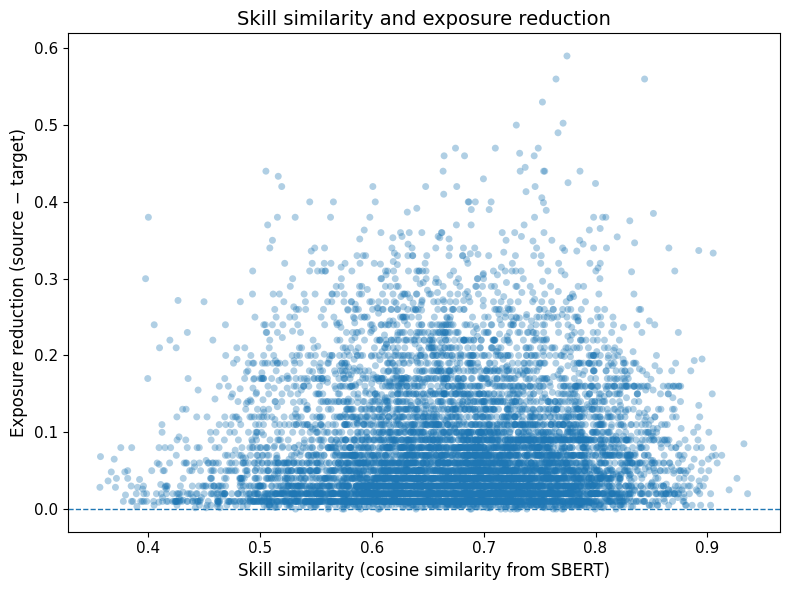

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(
    transitions["skill_similarity"],
    transitions["exposure_reduction"],
    alpha=0.35,
    s=25,
    edgecolors="none"
)

# Reference line at Δexposure = 0
plt.axhline(0, linestyle="--", linewidth=1)

# Optional reference lines for "good" transitions (can comment out)
# plt.axvline(0.6, linestyle=":", linewidth=1)
# plt.axhline(0.1, linestyle=":", linewidth=1)

plt.xlabel("Skill similarity (cosine similarity from SBERT)", fontsize=12)
plt.ylabel("Exposure reduction (source − target)", fontsize=12)
plt.title("Skill similarity and exposure reduction", fontsize=14)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()

plt.show()


Only the second one waas used for the paper.